**Helper Methods**

In [1]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, hamming_loss, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from math import ceil

# plotting libraties
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


def validation_metrics(name, classifier, X_val, y_val, labels):
  """
  function return summary of evaluation for the model 
  """
  y_preds = classifier.predict(X_val)
  y_preds_proba = classifier.predict_proba(X_val)

  # change evaluation methods if needed
  average = 'macro'
  accuracy = accuracy_score(y_val, y_preds)
  f1 = f1_score(y_val, y_preds, average=average)
  hammer_loss= hamming_loss(y_val, y_preds)
  precision = precision_score(y_val, y_preds, average=average, zero_division=np.nan)
  recall = recall_score(y_val, y_preds, average=average, zero_division=np.nan)
  roc_auc = roc_auc_score(y_val, y_preds_proba, average='weighted',multi_class='ovo')
  conf_matrix = confusion_matrix(y_val, y_preds, normalize='pred', labels=labels)


  class_report = classification_report(y_val, y_preds, zero_division=np.nan)

  df = pd.DataFrame({'accuracy': accuracy,
                     'f1': f1,
                     'hammer_loss': hammer_loss,
                     'precision': precision,
                     'recall': recall,
                     'roc_auc': roc_auc,
                     }, 
                    index=[name])
  
  return {
      'detail': df,
      'summary': class_report,
      'predictions': y_preds,
      'pred_proba': y_preds_proba,
      'conf_matrix': conf_matrix,
  }


# adjust the color in the confusion matrix based on max value in diagonal
ndigits = 1             # round up to nearest decimal, e.g. 0.33 -> 0.40
factor = 10**ndigits

def plot_conf_matrix(conf_matrix, labels, figsize=(15, 10)):
  """
  Plot confusion matrix
  """
  _, ax = plt.subplots(figsize=figsize)
  
  # find the max value along the diagonal
  vmax = 0
  for i in range(conf_matrix.shape[0]):
    vmax = max(vmax, conf_matrix[i,i])
    if i > 0:
      vmax = max(vmax, conf_matrix[i-1,i])
      vmax = max(vmax, conf_matrix[i,i-1])

  sns.set_theme(font_scale=1)
  sns.heatmap(conf_matrix, 
              xticklabels=labels, yticklabels=labels,
              annot=True, 
              ax=ax,
              vmin=0,vmax=ceil(vmax * factor) / factor, 
              cmap="Purples", 
              fmt=".2f", 
              annot_kws={"size": 8})
  ax.set_xlabel('Predictions')
  ax.set_ylabel('True lables')

In [2]:
# data structures and data handling
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# custom transformer function that converts a string column to a column containing the length of the strings
def apply_length_transform(X):
  return pd.concat([pd.Series(X[col].str.len(), name=col+'_len') for col in X.columns], axis=1)

# custom transformer providing the names for the columns transformed by the custom column transformer
def length_feature_names_out(self, cols):
  return [col+'_len' for col in cols]


def create_pipeline(classifier, vectorizer=None, type_column='variety'):
  # standard transformers for vintage and variety columns
  transformers = [('num', StandardScaler(with_mean=False), ['year']),
                  ('cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['country', type_column]),
                 ]
  
  # description column transformer
  if vectorizer is None:
    # use description length
    transformers.append(
      ('length_counter', Pipeline([('length_mapper', FunctionTransformer(apply_length_transform, feature_names_out=length_feature_names_out)), ('scaler', StandardScaler(with_mean=False))]), ['description'])
    )
  elif isinstance(vectorizer, CountVectorizer):
    transformers.append(
      ('tokenizer', Pipeline([('vectorizer', vectorizer), ('scaler', StandardScaler(with_mean=False))]),'description'),
    )
  else:
    # TF-IDF Vectorizer (for now)
    transformers.append(('vectorizer', vectorizer, 'description'))
  

  return Pipeline([('transformer',ColumnTransformer(transformers, remainder='drop')),
                   ('classifier',classifier)])

In [3]:
import time
from collections import namedtuple

PERF = namedtuple('PERF', ['feature', 'classifier', 'target', 'duration', 'accuracy_train', 'accuracy_test', 'conf_matrix_train', 'conf_matrix_test',
                           'f1_train','f1_test', 'hamming_loss_train','hamming_loss_test', 'precision_train', 'precision_test',
                           'recall_train','recall_test', 'roc_auc_train','roc_auc_test'])

def evaluate(classifier, X_train, y_train, X_test, y_test, target_name='points', vectorizer=None, params=None, labels=None) -> PERF:
  # define the parameters of the evaluation run
  classifier_name = classifier.__class__.__name__
  feature_name = 'len' if vectorizer is None else vectorizer.__class__.__name__

  # train the  model
  if params is None:
    model = create_pipeline(classifier, vectorizer=vectorizer)
    start = time.perf_counter()
    model.fit(X_train, y_train)
    duration = time.perf_counter() - start
  else:
    pass

  # calculate the performance results
  y_preds_train = model.predict(X_train)
  y_preds_test = model.predict(X_test)

  average = 'macro'

  return PERF(feature=feature_name, classifier=classifier_name, target=target_name, duration=duration,
              accuracy_train=accuracy_score(y_train, y_preds_train), accuracy_test=accuracy_score(y_test, y_preds_test),
              conf_matrix_train=confusion_matrix(y_train, y_preds_train, normalize='pred'), conf_matrix_test=confusion_matrix(y_test, y_preds_test, normalize='pred'),
              f1_train = f1_score(y_train, y_preds_train, average=average), f1_test = f1_score(y_test, y_preds_test, average=average),
              hamming_loss_train=hamming_loss(y_train, y_preds_train), hamming_loss_test=hamming_loss(y_test, y_preds_test),
              precision_train=precision_score(y_train, y_preds_train, average=average, zero_division=np.nan),precision_test=precision_score(y_test, y_preds_test, average=average, zero_division=np.nan),
              recall_train=recall_score(y_train, y_preds_train, average=average, zero_division=np.nan),recall_test=recall_score(y_test, y_preds_test, average=average, zero_division=np.nan),
              roc_auc_train=roc_auc_score(y_train, model.predict_proba(X_train), average='weighted',multi_class='ovo'),roc_auc_test=roc_auc_score(y_test, model.predict_proba(X_test), average='weighted',multi_class='ovo'),
             )
  

**Load Data**

In [4]:
from utils.wine_review_utils import load_data, RATINGS

ratings = [rating for rating, _ in RATINGS]

# Download the dataset
reviews = load_data()
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 93731 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      93731 non-null  object
 1   description  93731 non-null  object
 2   points       93731 non-null  int64 
 3   taster_name  93731 non-null  object
 4   variety      93731 non-null  object
 5   year         93731 non-null  int64 
 6   review_len   93731 non-null  int64 
 7   rating       93731 non-null  object
dtypes: int64(3), object(5)
memory usage: 6.4+ MB


,country,description,points,taster_name,variety,year,review_len,rating
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Kerin O’Keefe,White Blend,2013,172,very good
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,Roger Voss,Portuguese Red,2011,227,very good
2,US,"Tart and snappy, the flavors of lime flesh and...",87,Paul Gregutt,Pinot Gris,2013,186,very good
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,Alexander Peartree,Riesling,2013,199,very good
4,US,"Much like the regular bottling from 2012, this...",87,Paul Gregutt,Pinot Noir,2012,249,very good


**Explore the Data**

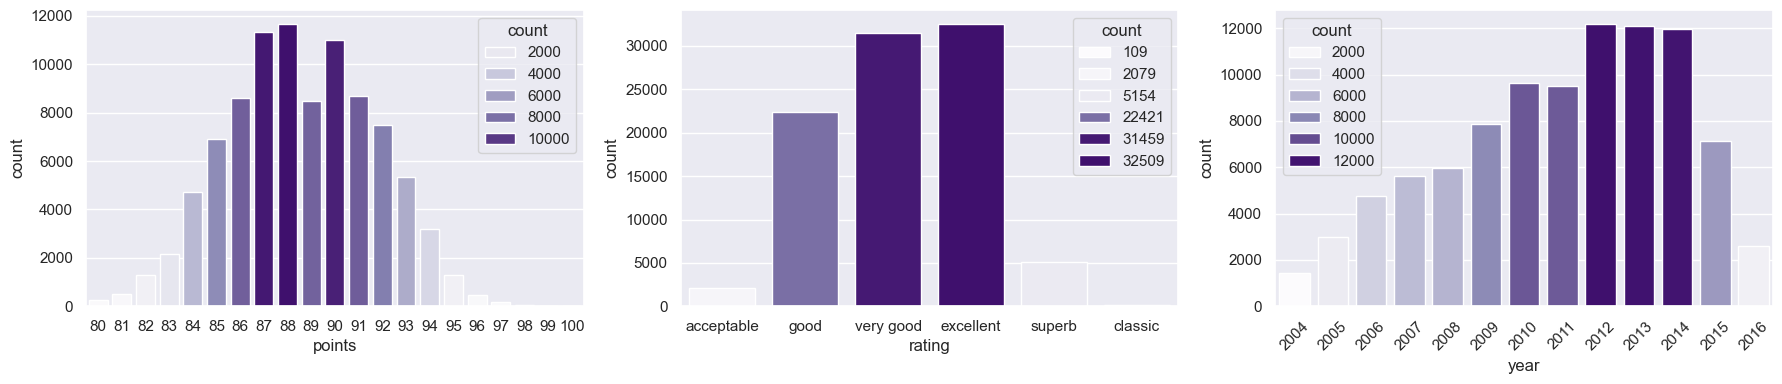

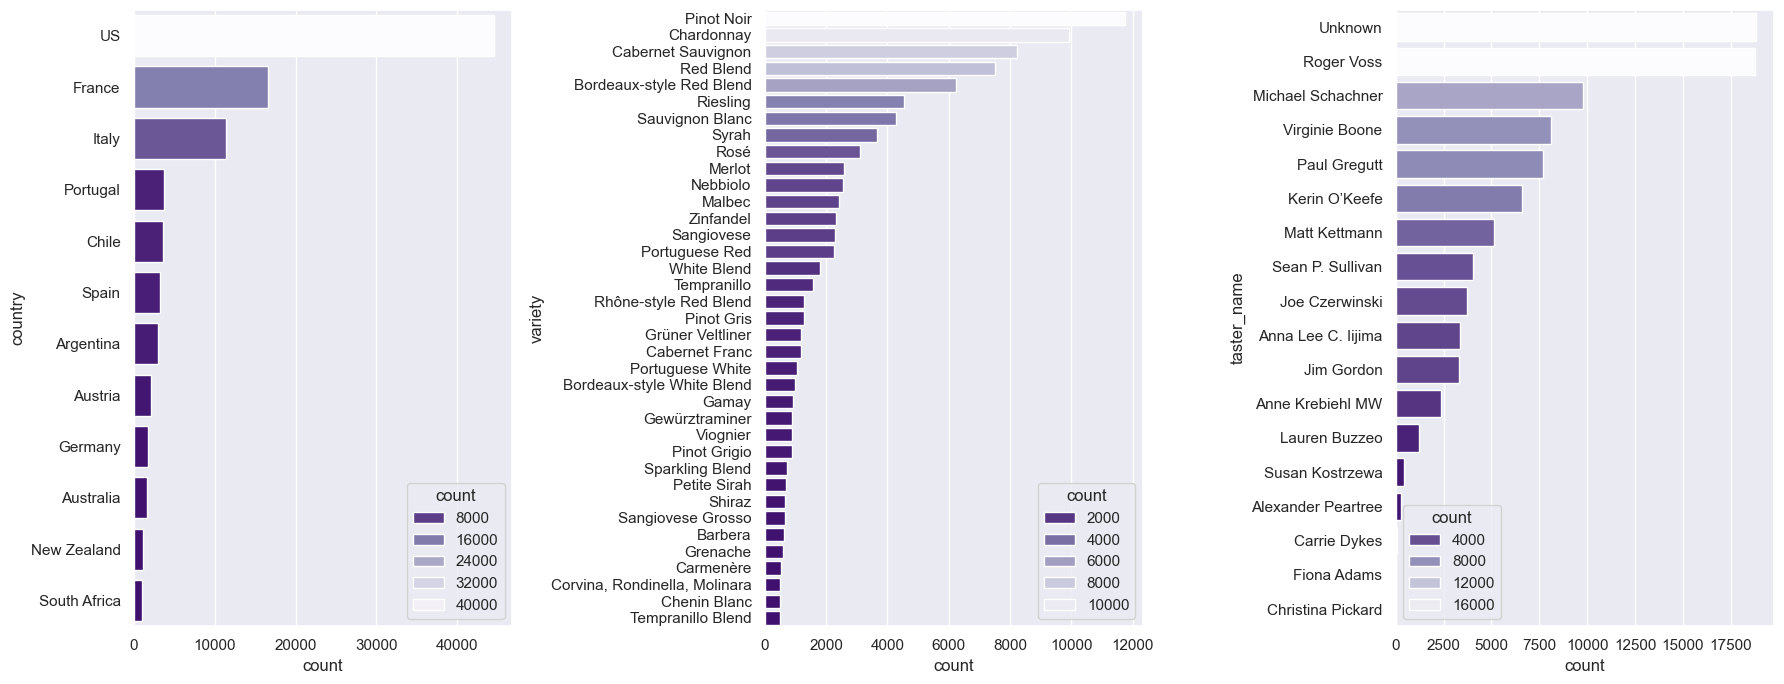

In [ ]:
by_ = lambda col, df = reviews: df[col].value_counts().to_frame()

reviews_by_points = by_('points')
reviews_by_rating = by_('rating')
reviews_by_year = by_('year')

reviews_by_country = by_('country')
reviews_by_variety = by_('variety')
reviews_by_taster = by_('taster_name')

fig, ax = plt.subplots(1,3, figsize=(18,4))
sns.barplot(reviews_by_points, hue='count', x='points', y='count', palette='Purples', ax=ax[0])
sns.barplot(reviews_by_rating, hue='count', x='rating', y='count', palette='Purples', ax=ax[1], order=ratings)
sns.barplot(reviews_by_year.iloc[:25], hue='count', x='year', y='count', palette='Purples', ax=ax[2])
ax[2].set_xticks(ax[2].get_xticks())
ax[2].set_xticklabels([tick.get_text().split('.')[0] for tick in ax[2].get_xticklabels()])
ax[2].tick_params(axis='x', labelrotation=45)
fig.tight_layout()
plt.show()

top_n = 50
fig, ax = plt.subplots(1,3, figsize=(18,7))
sns.barplot(reviews_by_country[:top_n], hue='count', y='country', x='count', palette='Purples_r', ax=ax[0])
sns.barplot(reviews_by_variety[:top_n], hue='count', y='variety', x='count', palette='Purples_r', ax=ax[1])
sns.barplot(reviews_by_taster[:top_n], hue='count', y='taster_name', x='count', palette='Purples_r', ax=ax[2])

fig.tight_layout()
plt.show()

**Classifiers to Try**

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

classifiers = [
  # feature matrix with variety, vintage & description Length + Logistic Regression
  (LogisticRegression(max_iter=500, C=0.5, random_state=42, solver='newton-cholesky'), None),
  # feature matrix with variety, vintage & description Length + Decision Tree Classifier
  (DecisionTreeClassifier(max_depth=50, min_samples_split=5, random_state=42) ,None),
  # feature matrix with variety, vintage & description Length + Multinomial Naive Bayes Classifier
  (MultinomialNB(), None),
  # feature matrix with variety, vintage & description Length + Support Vector Classifier
  (SVC(random_state = 42, probability=True), None),
  # feature matrix with variety, vintage & description Length + Gradient Boost Classifier
  (GradientBoostingClassifier(random_state=42), None),
  # feature matrix with variety, vintage & description Length + Ada Boost Classifier
  (AdaBoostClassifier(random_state=42), None),
  # feature matrix with variety, vintage & description Length + Random Forest Classifier
  (RandomForestClassifier(max_depth=5, random_state=42), None),
  # feature matrix with variety, vintage & description Length + Calibrated Classifier
  (CalibratedClassifierCV(), None),
]


feature matrices:
- [x] description length
- [ ] bag of words
- [ ] tf-idf
- [ ] spacy tokens
- [ ] mpnet
- [ ] jina v3

classifiers:
- [x] LogisticRegression
- [x] DecisionTreeClassifier
- [x] MultinomialNB
- [x] SVC
- [x] GradientBoostingClassifier
- [x] AdaBoostClassifier
- [x] RandomForestClassifier
- [ ] XGBoost
- [ ] CatBoost
- [x] CalibratedClassifierCV
- [ ] Neural Networks

target feature:
- [x] points
- [ ] rating

hyperparameter tuning:
- [ ] LogisticRegression
- [ ] DecisionTreeClassifier
- [ ] MultinomialNB
- [ ] SVC
- [ ] GradientBoostingClassifier
- [ ] AdaBoostClassifier
- [ ] RandomForestClassifier
- [ ] XGBoost
- [ ] CatBoost



**Points as the Target**

In [ ]:
# define the classification target column
target_name = 'points'

le = LabelEncoder()
y = le.fit_transform(reviews[target_name])
X_train, X_test, y_train, y_test = train_test_split(reviews,y, test_size=0.2, random_state=42, stratify=y)

In [143]:
results = pd.DataFrame([
  evaluate(classifier, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, target_name=target_name, labels=ratings if target_name == 'rating' else np.unique(reviews.points), params=params)
  for classifier, params in classifiers
])
results

,feature,classifier,target,duration,accuracy_train,accuracy_test,conf_matrix_train,conf_matrix_test,f1_train,f1_test,hamming_loss_train,hamming_loss_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test
0,len,LogisticRegression,points,38.662334,0.190787,0.188564,"[[0.5, 0.125, 0.10138888888888889, 0.099264705...","[[0.0, 0.0, 0.10382513661202186, 0.125, 0.0127...",0.111297,0.101234,0.809213,0.811436,0.200017,0.163202,0.109530,0.103172,0.787481,0.789231
1,len,DecisionTreeClassifier,points,1.818041,0.594007,0.140663,"[[0.5548780487804879, 0.00510204081632653, 0.0...","[[0.05, 0.025806451612903226, 0.02747252747252...",0.548584,0.099969,0.405993,0.859337,0.653370,0.114767,0.537545,0.099274,0.975814,0.560698
2,len,MultinomialNB,points,0.117829,0.157527,0.153305,"[[0.0, 0.0, 0.0, 0.0, 0.07936507936507936, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.10344827586206896, 0.0...",0.059741,0.057812,0.842473,0.846695,0.166234,0.150246,0.070233,0.068359,0.705283,0.693385
3,len,SVC,points,2964.769957,0.124387,0.124393,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...",0.010536,0.010536,0.875613,0.875607,0.124387,0.124393,0.047619,0.047619,0.748925,0.754540
4,len,GradientBoostingClassifier,points,144.139259,0.214846,0.184670,"[[0.5576923076923077, 0.052083333333333336, 0....","[[0.17857142857142858, 0.07142857142857142, 0....",0.199209,0.122815,0.785154,0.815330,0.309726,0.174683,0.174099,0.116861,0.786864,0.771622
5,len,AdaBoostClassifier,points,2.756763,0.151339,0.148344,"[[0.0, 0.0, 0.0, 0.0, 0.0037572797294758596, 0...","[[0.0, 0.0, 0.0, 0.0, 0.005818181818181818, 0....",0.055608,0.053918,0.848661,0.851656,0.149306,0.140285,0.070921,0.069253,0.686759,0.689584
6,len,RandomForestClassifier,points,3.460508,0.168156,0.163333,"[[0.0, 0.0, 0.0, 0.0, 0.016129032258064516, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.036036036036...",0.043403,0.041018,0.831844,0.836667,0.291740,0.228216,0.068650,0.066581,0.753211,0.749311
7,len,CalibratedClassifierCV,points,10.209156,0.177318,0.177202,"[[1.0, 0.16666666666666666, 0.1590909090909091...","[[0.0, 0.2, 0.13513513513513514, 0.15068493150...",0.081967,0.076259,0.822682,0.822798,0.280863,0.180974,0.086166,0.083362,0.769350,0.764852


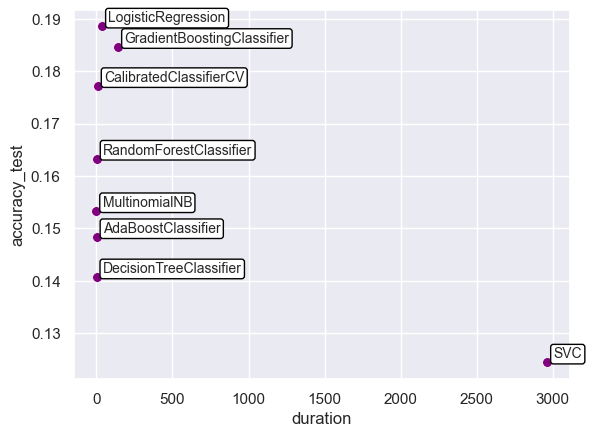

In [144]:
ax = sns.scatterplot(results, x='duration', y='accuracy_test', s=50, color='purple')

# Annotate each point with its label
for i, row in results.iterrows():
    # ax.set_ylim(.0, .20)
    ax.text(row['duration']+40, row['accuracy_test']+.00025, row['classifier'], fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), 
            horizontalalignment='left', verticalalignment='bottom')

# Show the plot
plt.show()

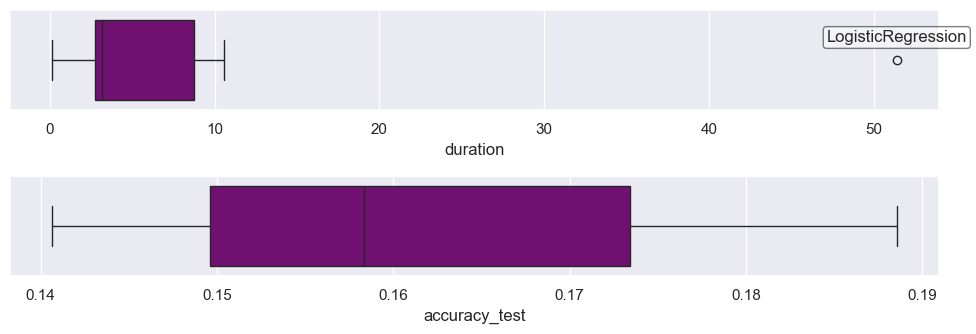

In [ ]:
import warnings

fig, axes =plt.subplots(2,1, figsize=(10, 3.5))

ax = sns.boxplot(results, x='duration', color='purple', ax=axes[0])


# Iterate through fliers and add annotations
for i, flier in enumerate(ax.findobj(match=lambda x: type(x) == plt.Line2D and x.get_marker() == 'o')):
    x_data, y_data = flier.get_data()
    for x, y in zip(x_data, y_data):
        classifier=results.query(f'duration == {x}').classifier.values[0]
        ax.text(x, y-0.15, f'{classifier}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.2'))

ax = sns.boxplot(results, x='accuracy_test', color='purple', ax=axes[1])
with warnings.catch_warnings():
  warnings.filterwarnings(action='ignore', category=UserWarning)
  ax.set_xticklabels([f'{float(v):.0%}' for v in ax.get_xticks()])

plt.tight_layout()
plt.show()

In [146]:
classifiers = [
  # feature matrix with variety, vintage & description Length + Logistic Regression
  (LogisticRegression(max_iter=500, C=0.5, random_state=42, solver='newton-cholesky'), None),
  # feature matrix with variety, vintage & description Length + Decision Tree Classifier
  (DecisionTreeClassifier(max_depth=50, min_samples_split=5, random_state=42) ,None),
  # feature matrix with variety, vintage & description Length + Multinomial Naive Bayes Classifier
  (MultinomialNB(), None),
  # feature matrix with variety, vintage & description Length + Support Vector Classifier
  # (SVC(random_state = 42, probability=True), None),
  # feature matrix with variety, vintage & description Length + Gradient Boost Classifier
  # (GradientBoostingClassifier(random_state=42), None),
  # feature matrix with variety, vintage & description Length + Ada Boost Classifier
  (AdaBoostClassifier(random_state=42), None),
  # feature matrix with variety, vintage & description Length + Random Forest Classifier
  (RandomForestClassifier(max_depth=5, random_state=42), None),
  # feature matrix with variety, vintage & description Length + Calibrated Classifier
  (CalibratedClassifierCV(), None),
]

results = pd.DataFrame([
  evaluate(classifier, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, target_name=target_name, labels=ratings if target_name == 'rating' else np.unique(reviews.points), params=params)
  for classifier, params in classifiers
])
results

,feature,classifier,target,duration,accuracy_train,accuracy_test,conf_matrix_train,conf_matrix_test,f1_train,f1_test,hamming_loss_train,hamming_loss_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test
0,len,LogisticRegression,points,51.410619,0.190787,0.188564,"[[0.5, 0.125, 0.10138888888888889, 0.099264705...","[[0.0, 0.0, 0.10382513661202186, 0.125, 0.0127...",0.111297,0.101234,0.809213,0.811436,0.200017,0.163202,0.109530,0.103172,0.787481,0.789231
1,len,DecisionTreeClassifier,points,3.034611,0.594007,0.140663,"[[0.5548780487804879, 0.00510204081632653, 0.0...","[[0.05, 0.025806451612903226, 0.02747252747252...",0.548584,0.099969,0.405993,0.859337,0.653370,0.114767,0.537545,0.099274,0.975814,0.560698
2,len,MultinomialNB,points,0.147210,0.157527,0.153305,"[[0.0, 0.0, 0.0, 0.0, 0.07936507936507936, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.10344827586206896, 0.0...",0.059741,0.057812,0.842473,0.846695,0.166234,0.150246,0.070233,0.068359,0.705283,0.693385
3,len,AdaBoostClassifier,points,2.613762,0.151339,0.148344,"[[0.0, 0.0, 0.0, 0.0, 0.0037572797294758596, 0...","[[0.0, 0.0, 0.0, 0.0, 0.005818181818181818, 0....",0.055608,0.053918,0.848661,0.851656,0.149306,0.140285,0.070921,0.069253,0.686759,0.689584
4,len,RandomForestClassifier,points,3.296431,0.168156,0.163333,"[[0.0, 0.0, 0.0, 0.0, 0.016129032258064516, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.036036036036...",0.043403,0.041018,0.831844,0.836667,0.291740,0.228216,0.068650,0.066581,0.753211,0.749311
5,len,CalibratedClassifierCV,points,10.557259,0.177771,0.176775,"[[0.5, 0.25, 0.14893617021276595, 0.1428571428...","[[0.0, 0.25, 0.13513513513513514, 0.1525423728...",0.082550,0.075197,0.822229,0.823225,0.303467,0.153292,0.086511,0.082585,0.769441,0.764761


In [147]:
high = results.duration.quantile(.75)
threshold = high + 1.5*(high-results.duration.quantile(.25))

outliers = .001

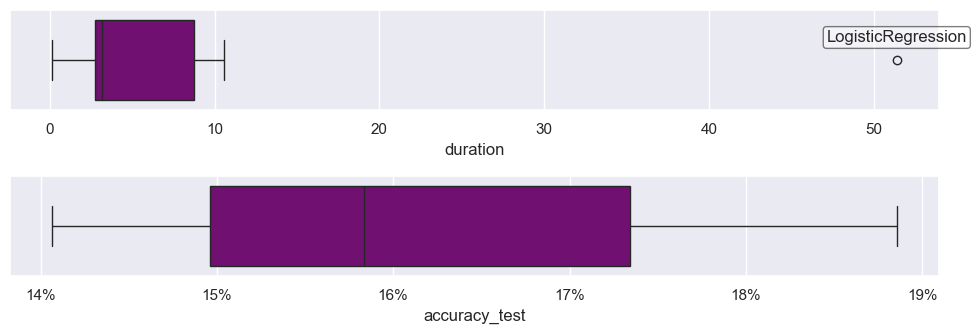

In [ ]:
import warnings

fig, axes =plt.subplots(2,1, figsize=(10, 3.5))

ax = sns.boxplot(results, x='duration', color='purple', ax=axes[0])


# Iterate through fliers and add annotations
for i, flier in enumerate(ax.findobj(match=lambda x: type(x) == plt.Line2D and x.get_marker() == 'o')):
    x_data, y_data = flier.get_data()
    for x, y in zip(x_data, y_data):
        classifier=results.query(f'duration == {x}').classifier.values[0]
        ax.text(x, y-0.15, f'{classifier}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.2'))

ax = sns.boxplot(results, x='accuracy_test', color='purple', ax=axes[1])
with warnings.catch_warnings():
  warnings.filterwarnings(action='ignore', category=UserWarning)
  ax.set_xticklabels([f'{float(v):.0%}' for v in ax.get_xticks()])

plt.tight_layout()
plt.show()

**Feature Selection**

In [7]:
# define the classification target column
target_name = 'points'

le = LabelEncoder()
y = le.fit_transform(reviews[target_name])
X_train, X_test, y_train, y_test = train_test_split(reviews.drop(['points', 'rating', 'review_len', 'taster_name'], axis=1),y, test_size=0.2, random_state=42, stratify=y)
X_train

,country,description,variety,year
18915,France,"The estate belongs to the Borie family, one of...",Bordeaux-style Red Blend,2012
89442,Australia,"Truth be told, the difference in quality betwe...",Shiraz,2007
90311,US,Fresh-pressed blackberry aromas leap out of th...,Petite Sirah,2013
3253,Italy,This blend of Sangiovese and 10% Merlot opens ...,Red Blend,2009
126491,US,"Fruity and tasting of lemon, melon and pineapp...",Pinot Gris,2011
...,...,...,...,...
59693,US,"A new, high-end offering from this producer, t...",Cabernet Sauvignon,2013
18088,US,"Easy to like now for its rich, exuberant flavo...",Pinot Noir,2008
45850,US,Briary berry and cedar flavors are marred by l...,Zinfandel,2010
34310,Italy,Here's a bright and easy-drinking wine made fr...,White Blend,2012


In [11]:
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import spacy

nlp = spacy.load("en_core_web_lg")

def preprocess(doc):
  # drop punctuation, proper nouns, numbers and stop words
  keep = lambda token: (token[1] not in ['PUNCT','PROPN', 'NUM']) and (token[2] == 0)
  # run the preprocessing pipeline
  return (' '.join(map(lambda token: token[0], filter(keep, [(w.lemma_, w.pos_, w.is_stop) for w in nlp(doc)])))).strip()

swords = stopwords.words('english') + ['year', 'years', 'wine', 'wines', 'variety', 'country']

with_vectorizer = lambda vectorizer: create_pipeline(RandomForestClassifier(max_depth=2, random_state=42), vectorizer)

pipelines = [
  with_vectorizer(None),
  with_vectorizer(CountVectorizer(stop_words=swords, min_df=.015, max_df=.95)),
  with_vectorizer(TfidfVectorizer(stop_words=swords, min_df=.015, max_df=.95)),
  with_vectorizer(CountVectorizer(preprocessor=preprocess)),

]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# given the training and test data set, train each pipeline

def get_vectorizer(pipe):
  if isinstance(pipe.named_steps['transformer'].transformers_[2][1], Pipeline):
    if 'length_mapper' in pipe.named_steps['transformer'].transformers_[2][1].named_steps:
      return 'Description Length'
    return pipe.named_steps['transformer'].transformers_[2][1].named_steps['vectorizer'].__class__.__name__
  return pipe.named_steps['transformer'].transformers_[2][1].__class__.__name__


for pipeline in pipelines:
  pipeline.fit(X_train, y_train)
  print(get_vectorizer(pipeline), f'{pipeline.score(X_test, y_test):.1%}')

Description Length 15.7%
CountVectorizer 14.2%
TfidfVectorizer 14.2%


KeyboardInterrupt: 